In [140]:
from utils import initialize_model, train_stepLR, train_cosine, perform_train
import gym
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import random
import torch.optim as optim
import torch.optim as optim
import csv

In [21]:
# Define the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
all_env = list(gym.envs.registry.keys())

print('Total Environments in Gym version {} : {}'.format(gym.__version__,len(all_env)))

Total Environments in Gym version 0.25.2 : 996


## Let's start the environment

In [23]:
#define environment
env = gym.make("AssaultDeterministic-v4", render_mode="rgb_array")

obs = env.reset()

# Inspect the observation
print("Observation shape:", obs.shape)
print("Observation dtype:", obs.dtype)

#Inspect action space
num_actions = env.action_space.n
print("Number of possible actions:", num_actions)

Observation shape: (210, 160, 3)
Observation dtype: uint8
Number of possible actions: 7


In [44]:
#Now we define the hyper parameters:
learning_rate = 0.0001
gamma = 0.99                      # Discount factor
epsilon = 1.0                     # Initial exploration rate
epsilon_decay = 0.995             # Epsilon decay rate
epsilon_min = 0.1                 # Minimum epsilon
replay_buffer_size = 100000       # Replay buffer size
batch_size = 1                  # Batch size for training
target_update_frequency = 1000    # Update target network after these many steps
max_episodes = 1000               # Maximum number of episodes
max_steps_per_episode = 10000     # Maximum steps per episode

Now we define the Q-Network based on the paper architecture

In [123]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        """
        Initialize the DQN network.
        
        :param input_shape: Tuple representing the input shape (channels, height, width).
        :param num_actions: Number of possible actions (output Q-values for each action).
        """
        super(DQN, self).__init__()
        
        # First convolutional layer: 32 filters of size 8x8 with stride 4
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=8, stride=4)
        
        # Second convolutional layer: 64 filters of size 4x4 with stride 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        
        # Third convolutional layer: 64 filters of size 3x3 with stride 1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # Calculate the flattened size after convolutions
        def conv_output_size(size, kernel_size, stride, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1

        conv_h = conv_output_size(
            conv_output_size(conv_output_size(input_shape[1], 8, 4), 4, 2), 3, 1
        )
        conv_w = conv_output_size(
            conv_output_size(conv_output_size(input_shape[2], 8, 4), 4, 2), 3, 1
        )
        linear_input_size = conv_h * conv_w * 64

        # Fully connected layer for output Q-values
        self.fc = nn.Linear(linear_input_size, num_actions)

    def forward(self, x):
        """
        Forward pass through the network.
        
        :param x: Input tensor of shape (batch_size, channels, height, width).
        :return: Tensor of shape (batch_size, num_actions) representing Q-values.
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.contiguous().view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.fc(x)
        return x

Pre processing the observation

In [124]:
def preprocess_observation(obs):
    """
    Preprocesses an Atari observation from (210, 160, 3) to (84, 84, 1) grayscale.

    :param obs: Raw observation from the environment (NumPy array of shape (210, 160, 3)).
    :return: Preprocessed observation (NumPy array of shape (84, 84, 1)).
    """
    # Convert to grayscale
    gray_obs = rgb2gray(obs)  # Shape: (210, 160)
    
    # Resize to 84x84
    resized_obs = resize(gray_obs, (84, 84), anti_aliasing=True)  # Shape: (84, 84)
    
    # Normalize pixel values to [0, 1]
    normalized_obs = resized_obs / 255.0
    
    # Add a channel dimension to make it (84, 84, 1)
    preprocessed_obs = np.expand_dims(normalized_obs, axis=-1)
    
    return preprocessed_obs

In [125]:

class ReplayBuffer:
    def __init__(self, capacity):
        """
        Initialize the replay buffer.

        :param capacity: Maximum number of transitions the buffer can hold.
        """
        self.capacity = capacity
        self.buffer = []
        self.position = 0  # Tracks the next position to overwrite when the buffer is full

    def store(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer.

        :param state: Current state (preprocessed).
        :param action: Action taken.
        :param reward: Reward received.
        :param next_state: Next state (preprocessed).
        :param done: Whether the episode is done.
        """
        # Create a tuple for the transition
        transition = (state, action, reward, next_state, done)

        # If the buffer isn't full, add the transition
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            # Overwrite the oldest transition
            self.buffer[self.position] = transition

        # Update the position to overwrite
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
    
        return random.sample(self.buffer, batch_size)
    
    

    def size(self):

        return len(self.buffer)

In [133]:
class DQNAgent:
    def __init__(self, env, replay_buffer, input_shape, num_actions, batch_size=32, gamma=0.99, lr=0.0001, target_update_frequency=1000):
        """
        Initialize the DQN agent.

        :param env: The Gym environment.
        :param replay_buffer: ReplayBuffer instance for experience storage.
        :param input_shape: Shape of the input state (e.g., (1, 84, 84)).
        :param num_actions: Number of possible actions in the environment.
        :param batch_size: Batch size for training.
        :param gamma: Discount factor for future rewards.
        :param lr: Learning rate for the optimizer.
        :param target_update_frequency: Steps between target network updates.
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update_frequency = target_update_frequency
        self.num_actions = num_actions

        # Q-network and target network
        self.q_network = DQN(input_shape, num_actions).to(device)
        self.target_network = DQN(input_shape, num_actions).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Initialize with same weights
        self.target_network.eval()  # Target network doesn't train

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Epsilon-greedy parameters
        self.epsilon = 1.0  # Start with full exploration
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1

        # Training step counter
        self.step_count = 0

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy.

        :param state: Current state of the environment.
        :return: Chosen action.
        """
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore: random action
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            state_tensor = state_tensor.permute(0, 3, 1, 2) 
            #print("state_tensor", state_tensor.size())
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()  # Exploit: max Q-value action
        

    def train_step(self):
        """
        Perform one training step.
        """
        if self.replay_buffer.size() < self.batch_size:
            return  # Not enough data to train

        # Sample a batch from the replay buffer
        single_transition = replay_buffer.sample(batch_size=1)[0]  
        state, action, reward, next_state, done = single_transition

        # Convert to tensors
        state = torch.tensor(state, dtype=torch.float32).to(device)
        action = torch.tensor(action, dtype=torch.int64).to(device)
        reward = torch.tensor(reward, dtype=torch.float32).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        dones = torch.tensor(done, dtype=torch.float32).to(device)

        # Compute current Q-values
        state = state.permute(2, 0, 1)  # Shape: (1, 84, 84)
        #print(state.size())
        state = state.unsqueeze(0)
        #print("state", state.size())
        q_values = self.q_network(state)
        #print("Q_values size", q_values.size())
        action = action.unsqueeze(0) 
        #print("action size", action.size())
        q_values = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        
        
        #formating for the network
        next_state = next_state.permute(2, 0, 1)  # Shape: (1, 84, 84)
        next_state = next_state.unsqueeze(0)
        #print("next state ", next_state.size())

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_state).max(1)[0]
        target_q_values = reward + self.gamma * next_q_values * (1 - done)

        # Compute loss and backpropagate
        loss = torch.nn.functional.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.step_count += 1
        if self.step_count % self.target_update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()

In [137]:
def train_dqn(agent, num_episodes, max_steps_per_episode, csv_filename):
    """
    Train the DQN agent.

    :param agent: The DQNAgent instance.
    :param num_episodes: Number of episodes to train.
    :param max_steps_per_episode: Maximum steps per episode.
    """
    
    # Initialize the CSV file with a header
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["episode", "total_reward", "loss", "epsilon"])  # Write the header row
        
        
    for episode in range(num_episodes):
        state = preprocess_observation(agent.env.reset())  # Reset the environment and preprocess the observation
        total_reward = 0
        loss = 0

        for step in range(max_steps_per_episode):
            # Select an action using the epsilon-greedy policy
            action = agent.select_action(state)

            # Take the action in the environment
            next_state, reward, done, _ = agent.env.step(action)
            next_state = preprocess_observation(next_state)

            # Store the transition in the replay buffer
            agent.replay_buffer.store(state, action, reward, next_state, done)

            # Train the network
            loss = agent.train_step()

            # Update total reward
            total_reward += reward

            # Update the current state
            state = next_state

            # Break the loop if the episode is done
            if done:
                break

        # Decay epsilon
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        
         # Save results to CSV
        with open(csv_filename, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([episode + 1, total_reward, loss, agent.epsilon])  # Append the row

        print(f"Episode {episode + 1}/{num_episodes} - Reward: {total_reward:.2f}, Loss: {loss:.4f}, Epsilon: {agent.epsilon:.4f}")

        
    print(f"Training results saved to {csv_filename}")

In [138]:
def evaluate_agent(agent, num_episodes, max_steps_per_episode):
    """
    Evaluate the DQN agent.

    :param agent: The DQNAgent instance.
    :param num_episodes: Number of evaluation episodes.
    :param max_steps_per_episode: Maximum steps per episode.
    """
    agent.epsilon = 0.0  # Turn off exploration
    total_rewards = []

    for episode in range(num_episodes):
        state = preprocess_observation(agent.env.reset())  # Reset the environment
        total_reward = 0

        for step in range(max_steps_per_episode):
            # Select the best action
            action = agent.select_action(state)

            # Take the action in the environment
            next_state, reward, done, _ = agent.env.step(action)
            next_state = preprocess_observation(next_state)

            # Update the total reward
            total_reward += reward

            # Update the current state
            state = next_state

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode + 1}/{num_episodes} - Reward: {total_reward:.2f}")

    print(f"Average Reward over {num_episodes} Episodes: {np.mean(total_rewards):.2f}")


In [141]:
replay_buffer = ReplayBuffer(capacity=100000)
csv_filename = "dqn_results.csv"

# Initialize agent
input_shape = (1, 84, 84)  # 4 stacked frames
num_actions = env.action_space.n
agent = DQNAgent(env, replay_buffer, input_shape, num_actions)

# Train the agent
num_episodes = 1000
max_steps_per_episode = 10000
train_dqn(agent, num_episodes, max_steps_per_episode, csv_filename=csv_filename)

# Evaluate the agent
evaluate_agent(agent, num_episodes=10, max_steps_per_episode=10000)

Episode 1/1000 - Reward: 189.00, Loss: 0.1557, Epsilon: 0.9950
Episode 2/1000 - Reward: 189.00, Loss: 0.0404, Epsilon: 0.9900
Episode 3/1000 - Reward: 231.00, Loss: 0.0012, Epsilon: 0.9851
Episode 4/1000 - Reward: 315.00, Loss: 0.1204, Epsilon: 0.9801
Episode 5/1000 - Reward: 273.00, Loss: 0.0212, Epsilon: 0.9752
Episode 6/1000 - Reward: 273.00, Loss: 0.1102, Epsilon: 0.9704
Episode 7/1000 - Reward: 336.00, Loss: 0.0004, Epsilon: 0.9655
Episode 8/1000 - Reward: 210.00, Loss: 0.0076, Epsilon: 0.9607
Episode 9/1000 - Reward: 168.00, Loss: 0.1629, Epsilon: 0.9559
Episode 10/1000 - Reward: 189.00, Loss: 0.1990, Epsilon: 0.9511
Episode 11/1000 - Reward: 315.00, Loss: 0.1992, Epsilon: 0.9464
Episode 12/1000 - Reward: 147.00, Loss: 0.0447, Epsilon: 0.9416
Episode 13/1000 - Reward: 315.00, Loss: 0.3157, Epsilon: 0.9369
Episode 14/1000 - Reward: 105.00, Loss: 1.0860, Epsilon: 0.9322
Episode 15/1000 - Reward: 189.00, Loss: 0.0064, Epsilon: 0.9276
Episode 16/1000 - Reward: 336.00, Loss: 0.1003, E

Episode 129/1000 - Reward: 210.00, Loss: 0.0008, Epsilon: 0.5238
Episode 130/1000 - Reward: 273.00, Loss: 0.0388, Epsilon: 0.5212
Episode 131/1000 - Reward: 210.00, Loss: 0.9426, Epsilon: 0.5186
Episode 132/1000 - Reward: 252.00, Loss: 0.3080, Epsilon: 0.5160
Episode 133/1000 - Reward: 126.00, Loss: 0.0452, Epsilon: 0.5134
Episode 134/1000 - Reward: 168.00, Loss: 0.0261, Epsilon: 0.5108
Episode 135/1000 - Reward: 147.00, Loss: 0.0009, Epsilon: 0.5083
Episode 136/1000 - Reward: 399.00, Loss: 1.8914, Epsilon: 0.5058
Episode 137/1000 - Reward: 273.00, Loss: 1.8808, Epsilon: 0.5032
Episode 138/1000 - Reward: 315.00, Loss: 0.5806, Epsilon: 0.5007
Episode 139/1000 - Reward: 189.00, Loss: 0.7266, Epsilon: 0.4982
Episode 140/1000 - Reward: 189.00, Loss: 0.0078, Epsilon: 0.4957
Episode 141/1000 - Reward: 273.00, Loss: 26.8072, Epsilon: 0.4932
Episode 142/1000 - Reward: 168.00, Loss: 0.0065, Epsilon: 0.4908
Episode 143/1000 - Reward: 231.00, Loss: 0.0971, Epsilon: 0.4883
Episode 144/1000 - Rewar

Episode 255/1000 - Reward: 210.00, Loss: 12.1563, Epsilon: 0.2785
Episode 256/1000 - Reward: 231.00, Loss: 432.9766, Epsilon: 0.2771
Episode 257/1000 - Reward: 378.00, Loss: 0.3146, Epsilon: 0.2758
Episode 258/1000 - Reward: 336.00, Loss: 4.0297, Epsilon: 0.2744
Episode 259/1000 - Reward: 168.00, Loss: 0.0011, Epsilon: 0.2730
Episode 260/1000 - Reward: 525.00, Loss: 0.0000, Epsilon: 0.2716
Episode 261/1000 - Reward: 189.00, Loss: 0.1319, Epsilon: 0.2703
Episode 262/1000 - Reward: 336.00, Loss: 2.1521, Epsilon: 0.2689
Episode 263/1000 - Reward: 231.00, Loss: 0.2520, Epsilon: 0.2676
Episode 264/1000 - Reward: 420.00, Loss: 0.0441, Epsilon: 0.2663
Episode 265/1000 - Reward: 420.00, Loss: 0.0178, Epsilon: 0.2649
Episode 266/1000 - Reward: 84.00, Loss: 5.9411, Epsilon: 0.2636
Episode 267/1000 - Reward: 252.00, Loss: 0.8317, Epsilon: 0.2623
Episode 268/1000 - Reward: 441.00, Loss: 0.2337, Epsilon: 0.2610
Episode 269/1000 - Reward: 399.00, Loss: 2.5348, Epsilon: 0.2597
Episode 270/1000 - Rewa

Episode 381/1000 - Reward: 357.00, Loss: 0.0054, Epsilon: 0.1481
Episode 382/1000 - Reward: 336.00, Loss: 0.2991, Epsilon: 0.1474
Episode 383/1000 - Reward: 189.00, Loss: 0.0308, Epsilon: 0.1466
Episode 384/1000 - Reward: 189.00, Loss: 0.0000, Epsilon: 0.1459
Episode 385/1000 - Reward: 315.00, Loss: 0.0648, Epsilon: 0.1452
Episode 386/1000 - Reward: 399.00, Loss: 0.0087, Epsilon: 0.1444
Episode 387/1000 - Reward: 357.00, Loss: 0.0574, Epsilon: 0.1437
Episode 388/1000 - Reward: 252.00, Loss: 0.2835, Epsilon: 0.1430
Episode 389/1000 - Reward: 378.00, Loss: 0.0165, Epsilon: 0.1423
Episode 390/1000 - Reward: 105.00, Loss: 0.0000, Epsilon: 0.1416
Episode 391/1000 - Reward: 147.00, Loss: 0.1101, Epsilon: 0.1409
Episode 392/1000 - Reward: 126.00, Loss: 0.0411, Epsilon: 0.1402
Episode 393/1000 - Reward: 420.00, Loss: 0.0026, Epsilon: 0.1395
Episode 394/1000 - Reward: 168.00, Loss: 7.5899, Epsilon: 0.1388
Episode 395/1000 - Reward: 105.00, Loss: 0.0024, Epsilon: 0.1381
Episode 396/1000 - Reward

Episode 507/1000 - Reward: 168.00, Loss: 0.0042, Epsilon: 0.1000
Episode 508/1000 - Reward: 168.00, Loss: 2.0978, Epsilon: 0.1000
Episode 509/1000 - Reward: 462.00, Loss: 0.0031, Epsilon: 0.1000
Episode 510/1000 - Reward: 399.00, Loss: 6.0353, Epsilon: 0.1000
Episode 511/1000 - Reward: 273.00, Loss: 0.0007, Epsilon: 0.1000
Episode 512/1000 - Reward: 294.00, Loss: 0.0046, Epsilon: 0.1000
Episode 513/1000 - Reward: 420.00, Loss: 0.6444, Epsilon: 0.1000
Episode 514/1000 - Reward: 336.00, Loss: 0.0012, Epsilon: 0.1000
Episode 515/1000 - Reward: 231.00, Loss: 0.0139, Epsilon: 0.1000
Episode 516/1000 - Reward: 378.00, Loss: 0.0611, Epsilon: 0.1000
Episode 517/1000 - Reward: 273.00, Loss: 1.6068, Epsilon: 0.1000
Episode 518/1000 - Reward: 336.00, Loss: 3.4545, Epsilon: 0.1000
Episode 519/1000 - Reward: 210.00, Loss: 0.0121, Epsilon: 0.1000
Episode 520/1000 - Reward: 273.00, Loss: 0.0015, Epsilon: 0.1000
Episode 521/1000 - Reward: 168.00, Loss: 0.0090, Epsilon: 0.1000
Episode 522/1000 - Reward

Episode 633/1000 - Reward: 336.00, Loss: 0.0533, Epsilon: 0.1000
Episode 634/1000 - Reward: 315.00, Loss: 0.3577, Epsilon: 0.1000
Episode 635/1000 - Reward: 378.00, Loss: 0.6818, Epsilon: 0.1000
Episode 636/1000 - Reward: 210.00, Loss: 0.1099, Epsilon: 0.1000
Episode 637/1000 - Reward: 399.00, Loss: 0.1568, Epsilon: 0.1000
Episode 638/1000 - Reward: 273.00, Loss: 0.5581, Epsilon: 0.1000
Episode 639/1000 - Reward: 231.00, Loss: 2.6495, Epsilon: 0.1000
Episode 640/1000 - Reward: 210.00, Loss: 0.0025, Epsilon: 0.1000
Episode 641/1000 - Reward: 336.00, Loss: 16.7802, Epsilon: 0.1000
Episode 642/1000 - Reward: 252.00, Loss: 17.1203, Epsilon: 0.1000
Episode 643/1000 - Reward: 63.00, Loss: 0.0799, Epsilon: 0.1000
Episode 644/1000 - Reward: 273.00, Loss: 0.3475, Epsilon: 0.1000
Episode 645/1000 - Reward: 357.00, Loss: 0.0422, Epsilon: 0.1000
Episode 646/1000 - Reward: 420.00, Loss: 0.2112, Epsilon: 0.1000
Episode 647/1000 - Reward: 315.00, Loss: 0.4155, Epsilon: 0.1000
Episode 648/1000 - Rewar

Episode 759/1000 - Reward: 462.00, Loss: 0.9021, Epsilon: 0.1000
Episode 760/1000 - Reward: 357.00, Loss: 0.0062, Epsilon: 0.1000
Episode 761/1000 - Reward: 252.00, Loss: 0.0015, Epsilon: 0.1000
Episode 762/1000 - Reward: 378.00, Loss: 0.0999, Epsilon: 0.1000
Episode 763/1000 - Reward: 273.00, Loss: 0.0005, Epsilon: 0.1000
Episode 764/1000 - Reward: 189.00, Loss: 0.0000, Epsilon: 0.1000
Episode 765/1000 - Reward: 420.00, Loss: 0.0094, Epsilon: 0.1000
Episode 766/1000 - Reward: 105.00, Loss: 0.0000, Epsilon: 0.1000
Episode 767/1000 - Reward: 441.00, Loss: 13.9233, Epsilon: 0.1000
Episode 768/1000 - Reward: 189.00, Loss: 0.3052, Epsilon: 0.1000
Episode 769/1000 - Reward: 315.00, Loss: 0.0836, Epsilon: 0.1000
Episode 770/1000 - Reward: 273.00, Loss: 0.0191, Epsilon: 0.1000
Episode 771/1000 - Reward: 315.00, Loss: 0.6230, Epsilon: 0.1000
Episode 772/1000 - Reward: 504.00, Loss: 0.0426, Epsilon: 0.1000
Episode 773/1000 - Reward: 252.00, Loss: 0.4156, Epsilon: 0.1000
Episode 774/1000 - Rewar

Episode 885/1000 - Reward: 42.00, Loss: 0.2180, Epsilon: 0.1000
Episode 886/1000 - Reward: 357.00, Loss: 6.6926, Epsilon: 0.1000
Episode 887/1000 - Reward: 315.00, Loss: 0.2883, Epsilon: 0.1000
Episode 888/1000 - Reward: 210.00, Loss: 0.0746, Epsilon: 0.1000
Episode 889/1000 - Reward: 189.00, Loss: 0.2466, Epsilon: 0.1000
Episode 890/1000 - Reward: 126.00, Loss: 0.0000, Epsilon: 0.1000
Episode 891/1000 - Reward: 294.00, Loss: 0.0107, Epsilon: 0.1000
Episode 892/1000 - Reward: 441.00, Loss: 0.7654, Epsilon: 0.1000
Episode 893/1000 - Reward: 399.00, Loss: 20.7203, Epsilon: 0.1000
Episode 894/1000 - Reward: 189.00, Loss: 19.1065, Epsilon: 0.1000
Episode 895/1000 - Reward: 189.00, Loss: 0.4041, Epsilon: 0.1000
Episode 896/1000 - Reward: 378.00, Loss: 0.0939, Epsilon: 0.1000
Episode 897/1000 - Reward: 336.00, Loss: 0.0006, Epsilon: 0.1000
Episode 898/1000 - Reward: 378.00, Loss: 27.0188, Epsilon: 0.1000
Episode 899/1000 - Reward: 105.00, Loss: 439.5259, Epsilon: 0.1000
Episode 900/1000 - Re

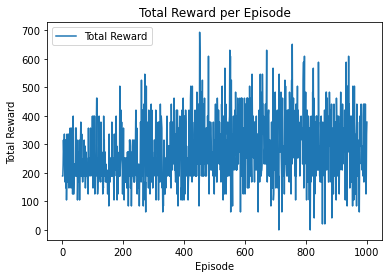

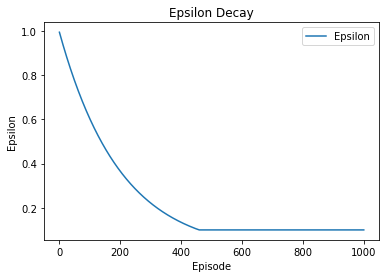

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV results
df = pd.read_csv("dqn_results.csv")

# Plot the total rewards over episodes
plt.plot(df["episode"], df["total_reward"], label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()
plt.show()

# Plot epsilon decay
plt.plot(df["episode"], df["epsilon"], label="Epsilon")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.legend()
plt.show()